# Finding molecular networks

With the electronic coupling between dimers calculated,
we can now turn our attention to evaluating how these dimer couplings can give a picture of the overall charge transport networks in the material.

The `kugupu.networks` submodule contains various methods for turning the coupling matrices into network graphs, represented using the `NetworkX` Python package.

In [2]:
import kugupu as kgp
import MDAnalysis as mda
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib notebook
%matplotlib inline

models available
{'ocelotml': <class 'kugupu.ocelotl_model.OcelotMLModel'>}


Firstly we load our previous system and coupling results:

In [3]:
# results = kgp.load_results('datafiles/results.hdf5')
results = kgp.load_results('myresults_chad.hdf5')
u = mda.Universe('datafiles/C6.data', 'datafiles/C6.dcd')

def add_names(u):
    # Guesses atom names based upon masses
    def approx_equal(x, y):
        return abs(x - y) < 0.1
    
    # mapping of atom mass to element
    massdict = {}
    for m in set(u.atoms.masses):
        for elem, elem_mass in mda.guesser.tables.masses.items():
            if approx_equal(m, elem_mass):
                massdict[m] = elem
                break
        else:
            raise ValueError
            
    u.add_TopologyAttr('names')
    for m, e in massdict.items():
        u.atoms[u.atoms.masses == m].names = e

add_names(u)

/Users/k2584788/.local/share/mamba/envs/forked_kugupu/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


## Generating molecular network representations

The `networks.find_networks` function then inspects a single frame of the `H_frag` matrix and converts this information into a graph.
Here we use the data in `results.H_frag[0]`,
with a threshold value of 1 meV to define if a dimer is coupled or not.

In [4]:
networks = kgp.networks.find_networks(fragments=u.atoms.fragments,
                                      H=results.H_frag[0],
                                      degeneracy=results.degeneracy,
                                      threshold=0.001)

This returns a list of `networkx.Graph` objects, each representing a connected component subgraph of the overall system. They are sorted by descending size, so we can easily inspect the largest molecular network in our system:

In [5]:
print("The largest network is {} molecules".format(len(networks[0])))

The largest network is 1 molecules


Or we can plot a distribution of network size, where we can see that there is a single large network of 45 molecules and several much smaller networks.

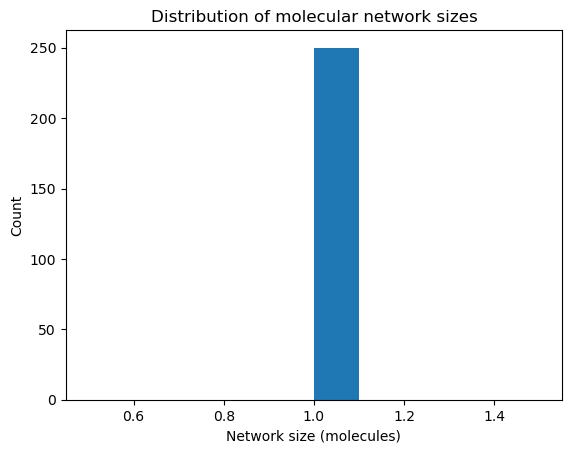

In [6]:
fig, ax = plt.subplots()

ax.hist([len(n) for n in networks])
ax.set_title('Distribution of molecular network sizes')
ax.set_xlabel('Network size (molecules)')
ax.set_ylabel('Count')
plt.show()

## Molecular network metrics

There are also various metrics built in to `kugupu.networks` for quantifying the transport across the molecular networks.

Simple graph metrics such as the Laplacian or adjacency matrix for a given can be found using the `networks.laplacian_matrix` and `networks.adjacency_matrix` functions respectively. These (and all other functions) allow a `weighted=True/False` keyword to 

In [7]:
kgp.networks.adjacency_matrix(networks[0])

array([[0.]])

The resistance distance matrix for a given graph can be found:

$$ \Omega_{ij} = \Gamma_{ii} + \Gamma_{jj} - 2 \Gamma_{ij} $$

Where $\Gamma$ represents the pseudo inverse of the Laplacian matrix for the network.

In [8]:
kgp.networks.resistance_distance_matrix(networks[0])

array([[0.]])

This is used to calculate various properties such as the Kirchoff index:

$$ K_f = 1/2 \sum_{i,j} \Omega_{i, j} $$

In [9]:
kgp.networks.kirchhoff_transport_index(networks[0])

0.0

Or the Kirchoff transport index

$$ K_t = \frac{1}{2 N^2}\sum_{i, j} A_{i, j} $$

Where $A$ is the admittance distance matrix, defined as

$$ A_{i, j} = 1 / \Omega_{i, j} \text{ if $i \ne j$ else $0$}$$

In [10]:
kgp.networks.kirchhoff_index(networks[0])

0.0